# Processing Doench 2014

Processing data from [Doench et al. 2014](https://www.nature.com/articles/nbt.3026)

### Data Filters
1. pdna or etp > mean pdna -3 std
2. match bin1, tier 1 score of 0

In [1]:
import pandas as pd
import poola.core as pool
import seaborn as sns
import gpplot
import matplotlib.pyplot as plt
from sklearn import preprocessing
import numpy as np
from scipy import stats
from sklearn.base import clone

from core import (add_transform_col,
                  compare_dataset_transforms)

In [2]:
mouse_reads = pd.read_csv('../data/raw/Doench2014_mouse_reads.csv')
human_reads = pd.read_csv('../data/raw/Doench2014_human_reads.csv')
rs_training_df = pd.read_csv('https://raw.githubusercontent.com/MicrosoftResearch/Azimuth/master/azimuth/data/FC_plus_RES_withPredictions.csv')
kim_processed_data = pd.read_csv('../data/external/Kim2019_train_activity_v1.csv')

In [3]:
rs_training_guides = rs_training_df[['30mer', 'Target gene']].drop_duplicates()

## Mouse Data

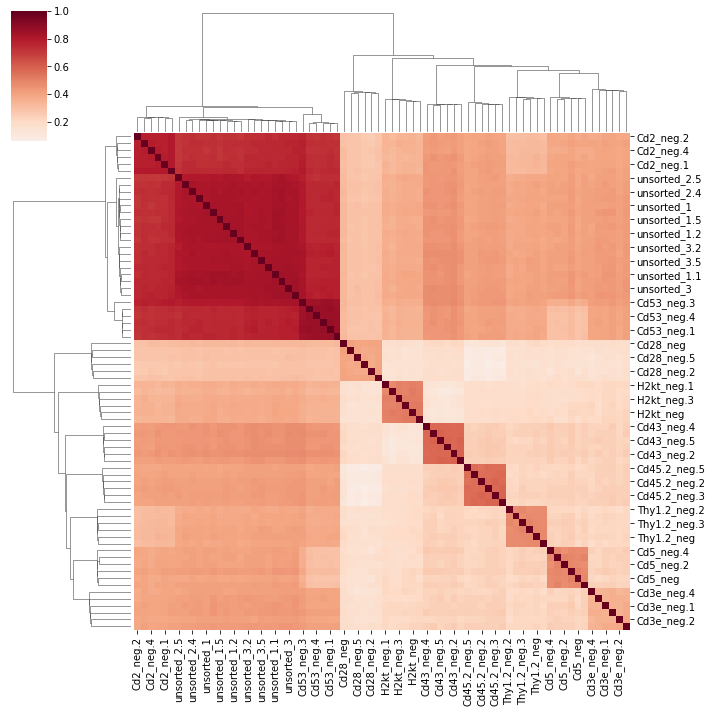

In [4]:
clean_mouse_reads = mouse_reads.copy()
clean_mouse_reads['sgRNA Sequence'] = clean_mouse_reads['sgRNA (21nts used for ID)'].str[0:20]
clean_mouse_reads = clean_mouse_reads.drop(['sgRNA (21nts used for ID)', 
                                            'Gene:Exon:Transcript:strand:count'], axis=1)
mouse_lognorms = pool.lognorm_columns(clean_mouse_reads, 
                                      clean_mouse_reads.columns[clean_mouse_reads.columns != 
                                                                'sgRNA Sequence'])
mouse_lognorm_cors = mouse_lognorms.corr()
sns.clustermap(mouse_lognorm_cors, cmap='RdBu_r', center=0)


In [5]:
mouse_long_lognorms = (mouse_lognorms.melt(id_vars='sgRNA Sequence', var_name='condition', 
                                           value_name='lognorm'))
mouse_long_lognorms['condition'] = mouse_long_lognorms['condition'].str.split('_', expand=True)[0]
mouse_avg_lognorms = (mouse_long_lognorms.groupby(['condition', 'sgRNA Sequence'])
                      .agg({'lognorm': 'mean'})
                      .reset_index())
mouse_spread_lognorms = (mouse_avg_lognorms.pivot_table(values='lognorm', index='sgRNA Sequence', 
                                                        columns='condition')
                         .reset_index())
mouse_filtered_lognorms = pool.filter_pdna(mouse_spread_lognorms, ['unsorted'])
print('Unsorted filtered: ' + str(mouse_spread_lognorms.shape[0] - mouse_filtered_lognorms.shape[0]))

Unsorted filtered: 112


In [6]:
mouse_lfcs = pool.calculate_lfcs(mouse_filtered_lognorms, ref_col='unsorted',
                                 target_cols = ['Cd2', 'Cd28', 'Cd3e', 'Cd43',
                                                'Cd45.2', 'Cd5', 'H2kt', 'Thy1.2'])
mouse_long_lfcs = (mouse_lfcs.melt(id_vars='sgRNA Sequence', var_name='condition', value_name='lfc'))

In [7]:
mouse_sg_list = list(mouse_lfcs['sgRNA Sequence'].unique())
mouse_design_df = pd.read_parquet('/Volumes/GoogleDrive/Shared drives/GPP Cloud /R&D/People/Peter/gpp-annotation-files/sgRNA_design_10090_GRCm38_SpyoCas9_CRISPRko_Ensembl_20200406.parquet',
                                  filters=[[('sgRNA Sequence', 'in', mouse_sg_list)]])

In [8]:
mouse_condition_map = {'Cd45.2': 'Ptprc',
                       'Cd43': 'Spn', 
                       'H2kt': 'H2-K1', 
                       'Thy1.2': 'Thy1'}
mouse_lfcs_designs = (mouse_long_lfcs
                      .merge(mouse_design_df, how = 'inner', on = 'sgRNA Sequence'))
mouse_lfcs_designs['condition'] = mouse_lfcs_designs['condition'].replace(mouse_condition_map)
mouse_lfcs_designs['neg_lfc'] = -mouse_lfcs_designs['lfc']
filtered_mouse_lfcs = mouse_lfcs_designs[mouse_lfcs_designs['# Off-Target Tier I Match Bin I Matches'] == '0'].copy()
print('Off target filtered: ' + str(mouse_lfcs_designs.shape[0] - filtered_mouse_lfcs.shape[0]))

Off target filtered: 8298


In [9]:
mouse_genes = mouse_design_df['Target Gene Symbol'].unique()
mouse_auc_list = []
for cond, df in filtered_mouse_lfcs.groupby('condition'):
    roc_aucs, _ = pool.get_roc_aucs(lfcs=df, tp_genes=[cond],
                                    fp_genes=mouse_genes[mouse_genes != cond],
                                    gene_col='Target Gene Symbol',
                                    score_col='neg_lfc', condition_col='condition')
    mouse_auc_list.append(roc_aucs)


mouse_auc_df = pd.concat(mouse_auc_list)

In [10]:
mouse_auc_df.sort_values('ROC-AUC')

,condition,ROC-AUC
0,Cd2,0.641208
0,Cd53,0.741403
0,Cd3e,0.892106
0,Cd5,0.914915
0,H2-K1,0.931493
0,Ptprc,0.939674
0,Cd28,0.970459
0,Spn,0.976427
0,Thy1,0.988410


In [11]:
mouse_conditions = ['Cd28', 'Cd3e', 'Cd5', 'H2-K1', 'Ptprc', 'Spn', 'Thy1']

In [12]:
mouse_auc_df.loc[mouse_auc_df['condition'].isin(mouse_conditions), 'ROC-AUC'].mean()

0.9447834721344159

In [13]:
mouse_model_df_list = []
for cond, df in filtered_mouse_lfcs.groupby('condition'):
    if cond in mouse_conditions:
        tp_sgs = df[df['Target Gene Symbol'] == cond].copy()
        mouse_model_df_list.append(tp_sgs)
mouse_model_df = pd.concat(mouse_model_df_list)

## Activity transform

We'll use the yeo-johnson transform as it yields a good correspondence with the
Kim endogenous dataset

z-score
min-max-scaler
robust-scaler
quantile-uniform


/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2334: UserWarning: n_quantiles (1000) is greater than the total number of samples (79). n_quantiles is set to n_samples.
/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2334: UserWarning: n_quantiles (1000) is greater than the total number of samples (85). n_quantiles is set to n_samples.
/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2334: UserWarning: n_quantiles (1000) is greater than the total number of samples (273). n_quantiles is set to n_samples.
/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2334: UserWarning: n_quantiles (1000) is greater than the total number of samples (85). n_quantiles is set to n_samples.
/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2334: UserWarning: n_quantiles (1000) is grea

quantile-normal
yeo-johnson


,transform,pearsonr,spearmanr,absolute_skew,absolute_difference
5,yeo-johnson,0.647525,0.592380,37,0.593112
3,quantile-uniform,0.616567,0.594349,17,0.184671
1,min-max-scaler,0.597592,0.597099,673,0.345238
0,z-score,0.597502,0.586735,15,0.649236
2,robust-scaler,0.585135,0.589203,177,0.471431
4,quantile-normal,0.555864,0.594349,17,0.700957


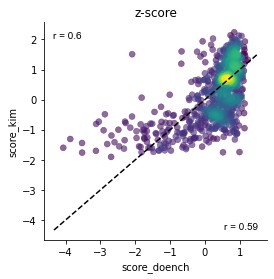

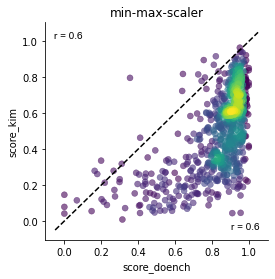

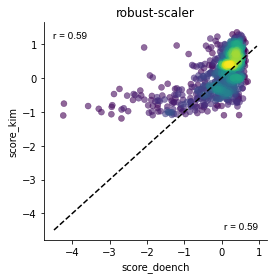

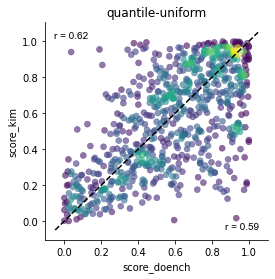

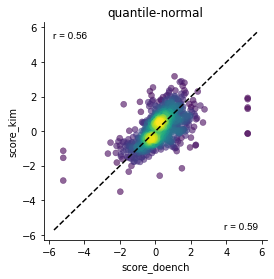

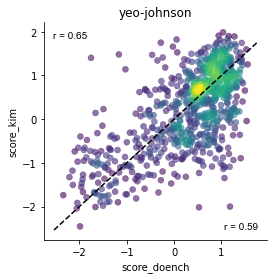

In [14]:
compare_dataset_transforms(df1=mouse_model_df, df1_score_col='lfc',
                           df1_name='_doench',
                           df2=kim_processed_data, df2_score_col='indel_freq',
                           df2_name='_kim',
                           merge_col='sgRNA Context Sequence',
                           df1_group_col=['Target Gene Symbol'])

In [15]:
mouse_model_df = add_transform_col(mouse_model_df, 'lfc', 'yeo-johnson',
                                   'scaled_lfc', group_col='Target Gene Symbol')

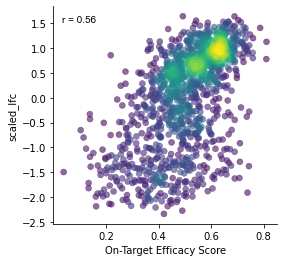

In [16]:
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(data=mouse_model_df, y='scaled_lfc', x='On-Target Efficacy Score')
gpplot.add_correlation(data=mouse_model_df, y='scaled_lfc', x='On-Target Efficacy Score')
sns.despine()

In [17]:
mouse_training_data = mouse_model_df[['sgRNA Sequence', 'sgRNA Context Sequence', 'Target Gene Symbol',
                                      'Target Cut %', 'scaled_lfc']].copy()
mouse_training_data

,sgRNA Sequence,sgRNA Context Sequence,Target Gene Symbol,Target Cut %,scaled_lfc
109,AAACAGTGACGTTCCGTCTC,AACGAAACAGTGACGTTCCGTCTCTGGAAT,Cd28,45.2,-2.103295
199,AAAGCAGTCGCCCCTGCTTG,TGGTAAAGCAGTCGCCCCTGCTTGTGGTAG,Cd28,13.4,0.138361
244,AAAGTCTCTGGCAGGGGCGT,CTGCAAAGTCTCTGGCAGGGGCGTAGGGCT,Cd28,94.7,0.316814
370,AACATGACTCCCCGGAGGCC,CATGAACATGACTCCCCGGAGGCCTGGGCT,Cd28,89.3,-1.889455
811,AAGTCTCTGGCAGGGGCGTA,TGCAAAGTCTCTGGCAGGGGCGTAGGGCTG,Cd28,94.5,0.526172
...,...,...,...,...,...
21662,TGCTGGTTCAGAACACATCC,AGCCTGCTGGTTCAGAACACATCCTGGATG,Thy1,86.5,0.114719
21887,TGGAGAGGGTGACGCGGGAG,TGGTTGGAGAGGGTGACGCGGGAGCGGTAC,Thy1,47.0,-0.284992
22211,TGGTGAAGTTGGCTAGGGTA,TTGGTGGTGAAGTTGGCTAGGGTAAGGACC,Thy1,55.6,1.161904
23426,TTCTCTATCCACAGACAAGC,CCCCTTCTCTATCCACAGACAAGCTGGTCA,Thy1,77.5,0.522909


### Difference with Rule Set 2 Training Data

In [18]:
(mouse_training_data.loc[
    ~mouse_training_data['sgRNA Context Sequence'].isin(rs_training_guides['30mer']),
 'Target Gene Symbol']
 .value_counts())

Ptprc    97
Cd3e     85
Spn      78
Cd5      38
Thy1     20
H2-K1    15
Cd28      6
Name: Target Gene Symbol, dtype: int64

In [19]:
mouse_training_data.to_csv('../data/processed/Doench2014_mouse_activity.csv', index=False)
mouse_model_df.to_csv('../data/interim/Doench2014_mouse_lfc.csv', index=False)

## Human Data

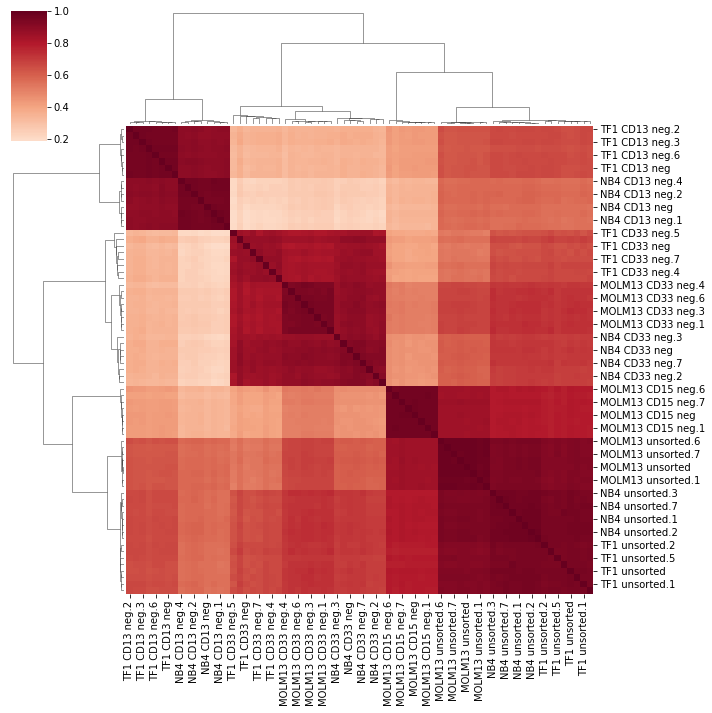

In [20]:
clean_human_reads = human_reads.copy()
clean_human_reads = clean_human_reads.drop(['Target', 
                                            'Position'], axis=1)
human_lognorms = pool.lognorm_columns(clean_human_reads, 
                                      clean_human_reads.columns[clean_human_reads.columns != 
                                                                'Sequence'])
human_lognorm_cors = human_lognorms.corr()
sns.clustermap(human_lognorm_cors, cmap='RdBu_r', center=0)


In [21]:
human_long_lognorms = (human_lognorms.melt(id_vars='Sequence', var_name='condition', 
                                           value_name='lognorm'))
human_long_lognorms['condition'] = human_long_lognorms['condition'].str.split('.', expand=True)[0]
human_avg_lognorms = (human_long_lognorms.groupby(['condition', 'Sequence'])
                      .agg({'lognorm': 'mean'})
                      .reset_index())
human_spread_lognorms = (human_avg_lognorms.pivot_table(values='lognorm', index='Sequence', 
                                                        columns='condition')
                         .reset_index())
human_filtered_lognorms = pool.filter_pdna(human_spread_lognorms, ['MOLM13 unsorted',
                                                                   'NB4 unsorted',
                                                                   'TF1 unsorted'])
print('Unsorted filtered: ' + str(human_spread_lognorms.shape[0] - human_filtered_lognorms.shape[0]))


Unsorted filtered: 13


In [22]:
human_lfcs = pool.calculate_lfcs(human_filtered_lognorms, ref_col='unsorted',
                                 ref_map={'MOLM13 CD15 neg': 'MOLM13 unsorted', 
                                          'MOLM13 CD33 neg': 'MOLM13 unsorted', 
                                          'NB4 CD13 neg': 'NB4 unsorted', 
                                          'NB4 CD33 neg': 'NB4 unsorted', 
                                          'TF1 CD13 neg': 'TF1 unsorted', 
                                          'TF1 CD33 neg': 'TF1 unsorted'})
human_long_lfcs = (human_lfcs.melt(id_vars='Sequence', var_name='condition', value_name='lfc'))

In [23]:
human_sg_list = list(human_lfcs['Sequence'].unique())
human_design_df = pd.read_parquet('/Volumes/GoogleDrive/Shared drives/GPP Cloud /R&D/People/Peter/gpp-annotation-files/sgRNA_design_9606_GRCh38_SpyoCas9_CRISPRko_Ensembl_20200401.parquet',
                                  filters=[[('sgRNA Sequence', 'in', human_sg_list)]])

In [24]:
human_lfcs_designs = (human_long_lfcs.rename({'Sequence': 'sgRNA Sequence'}, axis=1)
                      .merge(human_design_df, how = 'inner', on = 'sgRNA Sequence'))
human_lfcs_designs['neg_lfc'] = -human_lfcs_designs['lfc']
filtered_human_lfcs = human_lfcs_designs[human_lfcs_designs['# Off-Target Tier I Match Bin I Matches'] == '0'].copy()
print('Off target filtered: ' + str(human_lfcs_designs.shape[0] - filtered_human_lfcs.shape[0]))


Off target filtered: 324


In [25]:
human_genes = human_design_df['Target Gene Symbol'].unique()

In [26]:
human_expected_hits = {'MOLM13 CD15 neg': 'FUT4', 
                       'MOLM13 CD33 neg': 'CD33',
                       'NB4 CD33 neg': 'CD33', 
                       'TF1 CD33 neg': 'CD33', 
                       'NB4 CD13 neg': 'ANPEP', 
                       'TF1 CD13 neg': 'ANPEP'}
human_auc_list = []
for cond, df in filtered_human_lfcs.groupby('condition'):
    expected_hit = human_expected_hits[cond]
    roc_aucs, roc_df = pool.get_roc_aucs(lfcs=df, tp_genes=[expected_hit],
                                         fp_genes=human_genes[human_genes != expected_hit],
                                         gene_col='Target Gene Symbol',
                                         score_col='neg_lfc', condition_col='condition')
    human_auc_list.append(roc_aucs)

human_auc_df = pd.concat(human_auc_list)
human_auc_df.sort_values('ROC-AUC')

,condition,ROC-AUC
0,TF1 CD13 neg,0.932599
0,TF1 CD33 neg,0.933713
0,MOLM13 CD15 neg,0.964713
0,NB4 CD13 neg,0.974932
0,NB4 CD33 neg,0.979696
0,MOLM13 CD33 neg,0.994070


In [27]:
human_auc_df['ROC-AUC'].mean()

0.9632871152110409

In [28]:
human_model_df_list = []
for cond, df in filtered_human_lfcs.groupby('condition'):
    expected_hit = human_expected_hits[cond]
    tp_sgs = df[df['Target Gene Symbol'] == expected_hit].copy()
    human_model_df_list.append(tp_sgs)
human_model_df = pd.concat(human_model_df_list)

z-score
min-max-scaler
robust-scaler
quantile-uniform
quantile-normal
yeo-johnson


/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2334: UserWarning: n_quantiles (1000) is greater than the total number of samples (904). n_quantiles is set to n_samples.
/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2334: UserWarning: n_quantiles (1000) is greater than the total number of samples (501). n_quantiles is set to n_samples.
/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2334: UserWarning: n_quantiles (1000) is greater than the total number of samples (376). n_quantiles is set to n_samples.
/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2334: UserWarning: n_quantiles (1000) is greater than the total number of samples (904). n_quantiles is set to n_samples.
/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2334: UserWarning: n_quantiles (1000) is g

,transform,pearsonr,spearmanr,absolute_skew,absolute_difference
5,yeo-johnson,0.661100,0.613552,10,0.578086
2,robust-scaler,0.658052,0.623305,198,0.374045
0,z-score,0.657622,0.612220,14,0.593792
3,quantile-uniform,0.645853,0.617673,34,0.174866
1,min-max-scaler,0.621479,0.555777,402,0.206920
4,quantile-normal,0.616792,0.620772,26,0.622760


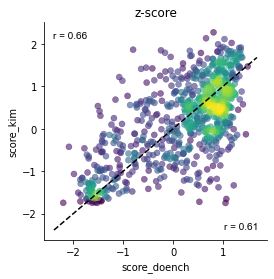

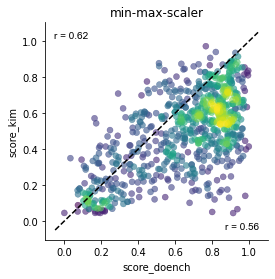

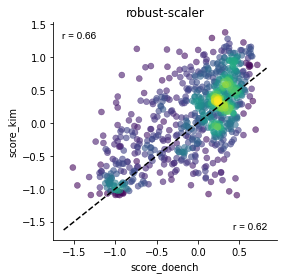

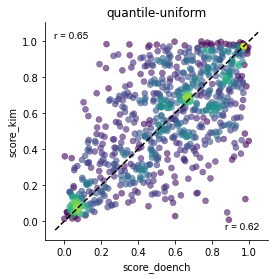

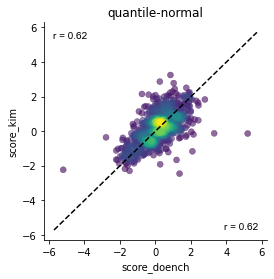

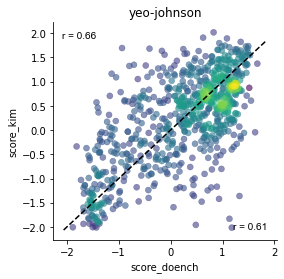

In [29]:
compare_dataset_transforms(df1=human_model_df, df1_score_col='lfc',
                           df1_name='_doench',
                           df2=kim_processed_data, df2_score_col='indel_freq',
                           df2_name='_kim',
                           merge_col='sgRNA Context Sequence',
                           df1_group_col='Target Gene Symbol',
                           df1_avg_col='sgRNA Context Sequence')

In [30]:
human_model_df = add_transform_col(human_model_df, 'lfc', 'yeo-johnson',
                                   'scaled_lfc', group_col='Target Gene Symbol')
human_avg_score = (human_model_df.groupby(['sgRNA Sequence', 'sgRNA Context Sequence', 'Target Gene Symbol',
                                          'Target Cut %', 'On-Target Efficacy Score'])
                   .agg({'scaled_lfc': 'mean'})
                   .reset_index())
human_avg_score['scaled_lfc'] = ((human_avg_score['scaled_lfc'] - human_avg_score['scaled_lfc'].mean())/
                                 human_avg_score['scaled_lfc'].std())

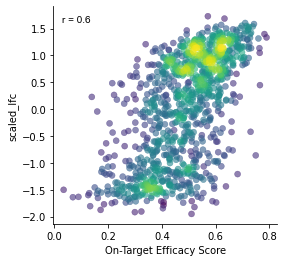

In [31]:
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(data=human_avg_score, y='scaled_lfc', x='On-Target Efficacy Score')
gpplot.add_correlation(data=human_avg_score, y='scaled_lfc', x='On-Target Efficacy Score')
sns.despine()

In [32]:
human_training_data = human_avg_score.drop('On-Target Efficacy Score', axis=1)
human_training_data

,sgRNA Sequence,sgRNA Context Sequence,Target Gene Symbol,Target Cut %,scaled_lfc
0,AAATAATACCAACAACTGGA,TCAGAAATAATACCAACAACTGGAGGGAGA,ANPEP,76.4,0.947185
1,AAATTTCTGGCTGCAAGTGC,ATCCAAATTTCTGGCTGCAAGTGCAGGAGT,CD33,6.7,-0.661867
2,AACAGCTCACTGATCTGGGC,GTCAAACAGCTCACTGATCTGGGCCGGCGT,ANPEP,48.1,0.786662
3,AACAGCTTGAGGTTTCAGTG,CCTGAACAGCTTGAGGTTTCAGTGGGGCCA,CD33,87.6,-0.860711
4,AACCGCTGGACCCTGCAGAT,CATGAACCGCTGGACCCTGCAGATGGGCTT,ANPEP,56.4,-0.436401
...,...,...,...,...,...
990,TTTCCTCGACCGCAACCCCG,TGCTTTTCCTCGACCGCAACCCCGCGGTCT,FUT4,90.1,0.862373
991,TTTCGAGAACTCGCAGCACC,TGGCTTTCGAGAACTCGCAGCACCTGGATT,FUT4,78.6,-0.518888
992,TTTCTGAAGTGAATGAAGAG,ATTATTTCTGAAGTGAATGAAGAGGGGTGT,ANPEP,75.3,0.638708
993,TTTGACCGCTCCGAGGTCTA,CATGTTTGACCGCTCCGAGGTCTATGGCCC,ANPEP,73.7,-1.407736


### Difference with Rule Set 2 Training Data

In [33]:
(human_training_data.loc[
    ~human_training_data['sgRNA Context Sequence'].isin(rs_training_guides['30mer']),
 'Target Gene Symbol']
 .value_counts())

FUT4     109
CD33      34
ANPEP     11
Name: Target Gene Symbol, dtype: int64

In [34]:
human_training_data.to_csv('../data/processed/Doench2014_human_activity.csv', index=False)
human_model_df.to_csv('../data/interim/Doench2014_human_lfc.csv', index=False)